# CoverMyMeds bootcamp project

## Import the things

In [1]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

## For DB management (if needed)
import sqlite3

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## For model fitting
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Read in CSV files

In [2]:
bridge = pd.read_csv("./CoverMyMeds_data/bridge.csv")
dim_claims = pd.read_csv("./CoverMyMeds_data/dim_claims.csv")
dim_date = pd.read_csv("./CoverMyMeds_data/dim_date.csv")
dim_pa = pd.read_csv("./CoverMyMeds_data/dim_pa.csv")

In [3]:
df2 = bridge.merge(dim_claims, on='dim_claim_id', how='left').copy()
df4 = df2.merge(dim_pa, on='dim_pa_id', how='left').copy()
mega_df = df4.merge(dim_date, on='dim_date_id', how='left').copy()
## Replace all NaN w/ -99
mega_df.fillna(-99,inplace=True)

In [127]:
## Check the datasets (index start at 0), [OPTIONAL]
## Size of claims = 1335576 entries
## Size of date = 1520 entries
## Size of PA = 555951
## Size of bridge = 1335576
mega_df

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,1.0,1,417380,A,75.0,0,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
1,2,-99.0,1,999001,A,-99.0,1,-99.0,-99.0,-99.0,-99.0,2017-01-01,2017,1,1,1,0,0,1
2,3,2.0,1,417740,A,76.0,0,1.0,0.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
3,4,-99.0,1,999001,A,-99.0,1,-99.0,-99.0,-99.0,-99.0,2017-01-01,2017,1,1,1,0,0,1
4,5,-99.0,1,417740,A,-99.0,1,-99.0,-99.0,-99.0,-99.0,2017-01-01,2017,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335571,1335572,555950.0,1095,417740,C,75.0,0,1.0,0.0,0.0,1.0,2019-12-31,2019,12,31,3,1,1,0
1335572,1335573,-99.0,1095,999001,C,-99.0,1,-99.0,-99.0,-99.0,-99.0,2019-12-31,2019,12,31,3,1,1,0
1335573,1335574,555951.0,1095,417380,C,70.0,0,0.0,0.0,1.0,0.0,2019-12-31,2019,12,31,3,1,1,0
1335574,1335575,-99.0,1095,999001,C,-99.0,1,-99.0,-99.0,-99.0,-99.0,2019-12-31,2019,12,31,3,1,1,0


## Intro Analysis

In [87]:
## Number of Claims by each Payer

#print("BIN\t#Claims")
#print(mega_df.bin.value_counts())
#print("BIN\t%Claims")
#print(round(mega_df.bin.value_counts(normalize=True)*100, 2))

m = mega_df.bin.value_counts()
n = round(mega_df.bin.value_counts(normalize=True)*100, 2)
payer_claims = [[i,m[i],n[i]] for i in m.index.values]
print(payer_claims)
payer_claims_df = pd.DataFrame(data=payer_claims,columns=['Payer','#Claims','%Claims'])
pcdf = payer_claims_df.copy()

payer_claims_df

[[999001, 640740, 47.97], [417614, 307323, 23.01], [417740, 213982, 16.02], [417380, 173531, 12.99]]


,Payer,#Claims,%Claims
0,999001,640740,47.97
1,417614,307323,23.01
2,417740,213982,16.02
3,417380,173531,12.99


In [40]:
## Number of Claims by each Drug

#print("Drug  #Claims")
#print(mega_df.drug.value_counts())
#print("Drug  %Claims")
#print(round(mega_df.drug.value_counts(normalize=True)*100, 2))

m = mega_df.drug.value_counts()
n = round(mega_df.drug.value_counts(normalize=True)*100, 2)
drug_claims = [[i,m[i],n[i]] for i in m.index.values]
drug_claims_df = pd.DataFrame(data=drug_claims,columns=['Drug','#Claims','%Claims'])
drug_claims_df

,Drug,#Claims,%Claims
0,A,679283,50.86
1,B,342750,25.66
2,C,313543,23.48


In [41]:
## Frequency of Reject Codes

#print(mega_df.reject_code.value_counts())
#print(round(mega_df.reject_code.value_counts(normalize=True)*100, 2))

m = mega_df.reject_code.value_counts()
n = round(mega_df.reject_code.value_counts(normalize=True)*100, 2)
reject_claims = [[i,m[i],n[i]] for i in m.index.values]
reject_claims_df = pd.DataFrame(data=reject_claims,columns=['Reject_Code','#Claims','%Claims'])
reject_claims_df

,Reject_Code,#Claims,%Claims
0,-99.0,779625,58.37
1,70.0,252206,18.88
2,75.0,217351,16.27
3,76.0,86394,6.47


In [42]:
## Data split by Individual Payer
payers = sorted(list(set(mega_df['bin'])))
payer1 = mega_df[mega_df.bin == payers[0]]
payer2 = mega_df[mega_df.bin == payers[1]]
payer3 = mega_df[mega_df.bin == payers[2]]
payer4 = mega_df[mega_df.bin == payers[3]]

## Payer's Claims numbers by drug
#print(round(payer1.drug.value_counts(normalize=True)*100, 2))
#print(round(payer2.drug.value_counts(normalize=True)*100, 2))
#print(round(payer3.drug.value_counts(normalize=True)*100, 2))
#print(round(payer4.drug.value_counts(normalize=True)*100, 2))


In [43]:
## Data split by Drug
drugs = sorted(list(set(mega_df['drug'])))

## Drug A
drug1 = mega_df[mega_df.drug == drugs[0]]
m = drug1.bin.value_counts()
payer_claims_df['#Drug_A'] = [m[i] for i in m.index.values]
n = round(drug1.bin.value_counts(normalize=True)*100, 2)
payer_claims_df['%Drug_A'] = [n[i] for i in n.index.values]

## Drug B
drug2 = mega_df[mega_df.drug == drugs[1]]
m = drug2.bin.value_counts()
payer_claims_df['#Drug_B'] = [m[i] for i in m.index.values]
n = round(drug2.bin.value_counts(normalize=True)*100, 2)
payer_claims_df['%Drug_B'] = [n[i] for i in n.index.values]

## Drug C
drug3 = mega_df[mega_df.drug == drugs[2]]
m = drug3.bin.value_counts()
payer_claims_df['#Drug_C'] = [m[i] for i in m.index.values]
n = round(drug3.bin.value_counts(normalize=True)*100, 2)
payer_claims_df['%Drug_C'] = [n[i] for i in n.index.values]

payer_claims_df

,Payer,#Claims,%Claims,#Drug_A,%Drug_A,#Drug_B,%Drug_B,#Drug_C,%Drug_C
0,999001,640740,47.97,325532,47.92,164658,48.04,150550,48.02
1,417614,307323,23.01,156497,23.04,78686,22.96,72140,23.01
2,417740,213982,16.02,108768,16.01,55035,16.06,50179,16.00
3,417380,173531,12.99,88486,13.03,44371,12.95,40674,12.97


In [67]:
## Data split by Drug
drugs = sorted(list(set(mega_df['drug'])))

## Drug A
drug1 = mega_df[mega_df.drug == drugs[0]]
m = drug1.bin.value_counts()
pcdf['#Drug_A'] = [m[i] for i in m.index.values]
#[pcdf['#Drug_A']]
#pcdf['%Drug_A'] = [n[i] for i in n.index.values]

## Drug B
drug2 = mega_df[mega_df.drug == drugs[1]]
m = drug2.bin.value_counts()
pcdf['#Drug_B'] = [m[i] for i in m.index.values]
#n = round(drug2.bin.value_counts(normalize=True)*100, 2)
#payer_claims_df['%Drug_B'] = [n[i] for i in n.index.values]

## Drug C
drug3 = mega_df[mega_df.drug == drugs[2]]
m = drug3.bin.value_counts()
pcdf['#Drug_C'] = [m[i] for i in m.index.values]
#n = round(drug3.bin.value_counts(normalize=True)*100, 2)
#payer_claims_df['%Drug_C'] = [n[i] for i in n.index.values]

A=[]
B=[]
C=[]
for i in range(len(m)):
    s = (pcdf['#Drug_A'][i]+pcdf['#Drug_B'][i]+pcdf['#Drug_C'][i])
    A.append(round(pcdf['#Drug_A'][i]/s,2))
    B.append(round(pcdf['#Drug_B'][i]/s,2))
    C.append(round(pcdf['#Drug_C'][i]/s,2))

pcdf['%Drug_A'] = A
pcdf['%Drug_B'] = B
pcdf['%Drug_C'] = C

pcdf

,Payer,#Claims,%Claims,#Drug_A,#Drug_B,#Drug_C,%Drug_A,%Drug_B,%Drug_C
0,999001,640740,47.97,325532,164658,150550,0.51,0.26,0.23
1,417614,307323,23.01,156497,78686,72140,0.51,0.26,0.23
2,417740,213982,16.02,108768,55035,50179,0.51,0.26,0.23
3,417380,173531,12.99,88486,44371,40674,0.51,0.26,0.23


In [68]:
p1d1 = payer1[payer1.drug == drugs[0]]

In [69]:
## Data split by Payer, by Drug
p1d1 = payer1[payer1.drug == drugs[0]]
p1d2 = payer1[payer1.drug == drugs[1]]
p1d3 = payer1[payer1.drug == drugs[2]]

p2d1 = payer2[payer2.drug == drugs[0]]
p2d2 = payer2[payer2.drug == drugs[1]]
p2d3 = payer2[payer2.drug == drugs[2]]

p3d1 = payer3[payer3.drug == drugs[0]]
p3d2 = payer3[payer3.drug == drugs[1]]
p3d3 = payer3[payer3.drug == drugs[2]]

p4d1 = payer4[payer4.drug == drugs[0]]
p4d2 = payer4[payer4.drug == drugs[1]]
p4d3 = payer4[payer4.drug == drugs[2]]

## Percentage of Reject Codes for a Drug by Payer
print(round(p1d1.reject_code.value_counts(normalize=True)*100, 2))
print(round(p1d2.reject_code.value_counts(normalize=True)*100, 2))
print(round(p1d3.reject_code.value_counts(normalize=True)*100, 2))

print(round(p2d1.reject_code.value_counts(normalize=True)*100, 2))
print(round(p2d2.reject_code.value_counts(normalize=True)*100, 2))
print(round(p2d3.reject_code.value_counts(normalize=True)*100, 2))

print(round(p3d1.reject_code.value_counts(normalize=True)*100, 2))
print(round(p3d2.reject_code.value_counts(normalize=True)*100, 2))
print(round(p3d3.reject_code.value_counts(normalize=True)*100, 2))

print(round(p4d1.reject_code.value_counts(normalize=True)*100, 2))
print(round(p4d2.reject_code.value_counts(normalize=True)*100, 2))
print(round(p4d3.reject_code.value_counts(normalize=True)*100, 2))

75.0    100.0
Name: reject_code, dtype: float64
-99.0    90.04
 76.0     9.96
Name: reject_code, dtype: float64
70.0    100.0
Name: reject_code, dtype: float64
70.0    100.0
Name: reject_code, dtype: float64
75.0    100.0
Name: reject_code, dtype: float64
-99.0    90.18
 76.0     9.82
Name: reject_code, dtype: float64
-99.0    90.05
 76.0     9.95
Name: reject_code, dtype: float64
70.0    100.0
Name: reject_code, dtype: float64
75.0    100.0
Name: reject_code, dtype: float64
-99.0    90.02
 76.0     9.98
Name: reject_code, dtype: float64
-99.0    90.06
 76.0     9.94
Name: reject_code, dtype: float64
-99.0    89.9
 76.0    10.1
Name: reject_code, dtype: float64


In [70]:
m = round(p1d2.reject_code.value_counts(normalize=True)*100, 2)
m[m.index.values[0]]

90.04

In [71]:
## Check sorting of reject_code
sorted(list(set(mega_df['reject_code'])))

[-99.0, 70.0, 75.0, 76.0]

In [72]:
## Data split by Reject Code
## first code in sorted list is NaN == -99
codes = sorted(list(set(mega_df['reject_code'])))
code0 = mega_df[mega_df.reject_code == codes[0]]
code1 = mega_df[mega_df.reject_code == codes[1]]
code2 = mega_df[mega_df.reject_code == codes[2]]
code3 = mega_df[mega_df.reject_code == codes[3]]

## Percentage of Claims by Reject Code for each Payer
print(round(code0.bin.value_counts(normalize=True)*100, 2))
print(round(code1.bin.value_counts(normalize=True)*100, 2))
print(round(code2.bin.value_counts(normalize=True)*100, 2))
print(round(code3.bin.value_counts(normalize=True)*100, 2))

999001    73.97
417740    12.56
417614     8.34
417380     5.12
Name: bin, dtype: float64
417614    62.05
417740    21.82
417380    16.13
Name: bin, dtype: float64
417380    40.71
417614    36.20
417740    23.09
Name: bin, dtype: float64
999001    74.16
417740    12.52
417614     8.20
417380     5.11
Name: bin, dtype: float64


In [73]:
## Data split by reject code, from block above

## Percent of Reject Code approved after PA
print(round(code0.pa_approved.value_counts(normalize=True)*100, 2))
print(round(code1.pa_approved.value_counts(normalize=True)*100, 2))
print(round(code2.pa_approved.value_counts(normalize=True)*100, 2))
print(round(code3.pa_approved.value_counts(normalize=True)*100, 2))

-99.0    100.0
Name: pa_approved, dtype: float64
0.0    50.07
1.0    49.93
Name: pa_approved, dtype: float64
1.0    94.8
0.0     5.2
Name: pa_approved, dtype: float64
1.0    88.37
0.0    11.63
Name: pa_approved, dtype: float64


In [74]:
c0p1 = code0[code0.bin == payers[0]]
c0p2 = code0[code0.bin == payers[1]]
c0p3 = code0[code0.bin == payers[2]]
c0p4 = code0[code0.bin == payers[3]]
print(round(c0p1.drug.value_counts(normalize=True)*100, 2))
print(round(c0p2.drug.value_counts(normalize=True)*100, 2))
print(round(c0p3.drug.value_counts(normalize=True)*100, 2))
print(round(c0p4.drug.value_counts(normalize=True)*100, 2))

B    100.0
Name: drug, dtype: float64
C    100.0
Name: drug, dtype: float64
A    100.0
Name: drug, dtype: float64
A    50.82
B    25.71
C    23.47
Name: drug, dtype: float64


In [117]:
D = sorted(list(set(mega_df['date_val'])))
d1 = mega_df[mega_df.date_val == D[0]]
d1.pa_approved.value_counts()

-99.0    129
 1.0      63
 0.0      31
Name: pa_approved, dtype: int64

In [119]:
## Data split by Date
D = sorted(list(set(mega_df['date_val'])))

pclaims = np.zeros((len(D),4))
dclaims = np.zeros((len(D),3))
rclaims = np.zeros((len(D),4))
paapprv = np.zeros((len(D),3))
# loop thru all date values
for i in range(len(D)):
    #grab all of the data for a single date_val
    d1 = mega_df[mega_df.date_val == D[i]]
    #grab the counts of claims for each variable on that date_val
    m = d1.bin.value_counts()
    n = d1.drug.value_counts()
    t = d1.reject_code.value_counts()
    g = d1.pa_approved.value_counts()
    #save the counts
    pclaims[i] = [m[j] for j in m.index.values]
    dclaims[i] = [n[j] for j in n.index.values]
    rclaims[i] = [t[j] for j in t.index.values]
    paapprv[i] = [g[j] for j in g.index.values]


In [120]:
print(paapprv)

[[129.  63.  31.]
 [640. 308. 129.]
 [825. 428. 186.]
 ...
 [338. 167.  40.]
 [856. 452. 144.]
 [946. 548. 169.]]


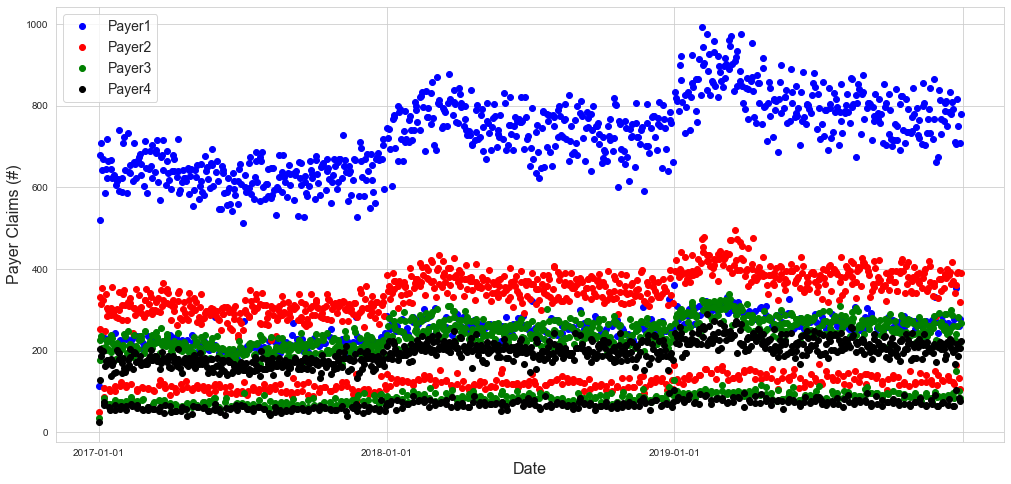

In [128]:
##Plot Payer Claims vs. Time

# import constants for the days of the week
from matplotlib.dates import MonthLocator
from matplotlib.dates import YearLocator
#from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

# tick on mondays every week
#xmajor_locator = WeekdayLocator(byweekday=MO)
xmajor_locator = YearLocator()
xminor_locator = MonthLocator()

plt.figure(figsize=(17,8))

plt.plot(D,pclaims[:,0],'bo',label='Payer1')
plt.plot(D,pclaims[:,1],'ro',label='Payer2')
plt.plot(D,pclaims[:,2],'go',label='Payer3')
plt.plot(D,pclaims[:,3],'ko',label='Payer4')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Payer Claims (#)", fontsize=16)
plt.legend(fontsize = 14,loc='best')

ax=plt.gca()
ax.xaxis.set_major_locator(xmajor_locator)
ax.xaxis.set_minor_locator(xminor_locator)

plt.show()

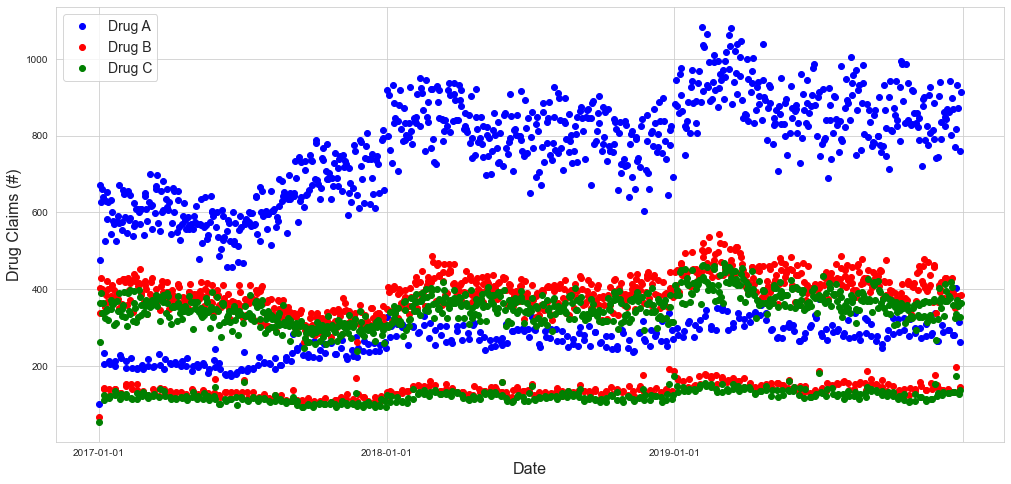

In [129]:
##Plot Drug Claims vs. Time

# import constants for the days of the week
from matplotlib.dates import MonthLocator
from matplotlib.dates import YearLocator
#from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

# tick on mondays every week
#xmajor_locator = WeekdayLocator(byweekday=MO)
xmajor_locator = YearLocator()
xminor_locator = MonthLocator()

plt.figure(figsize=(17,8))

plt.plot(D,dclaims[:,0],'bo',label='Drug A')
plt.plot(D,dclaims[:,1],'ro',label='Drug B')
plt.plot(D,dclaims[:,2],'go',label='Drug C')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Drug Claims (#)", fontsize=16)
plt.legend(fontsize = 14,loc='best')

ax=plt.gca()
ax.xaxis.set_major_locator(xmajor_locator)
ax.xaxis.set_minor_locator(xminor_locator)

plt.show()

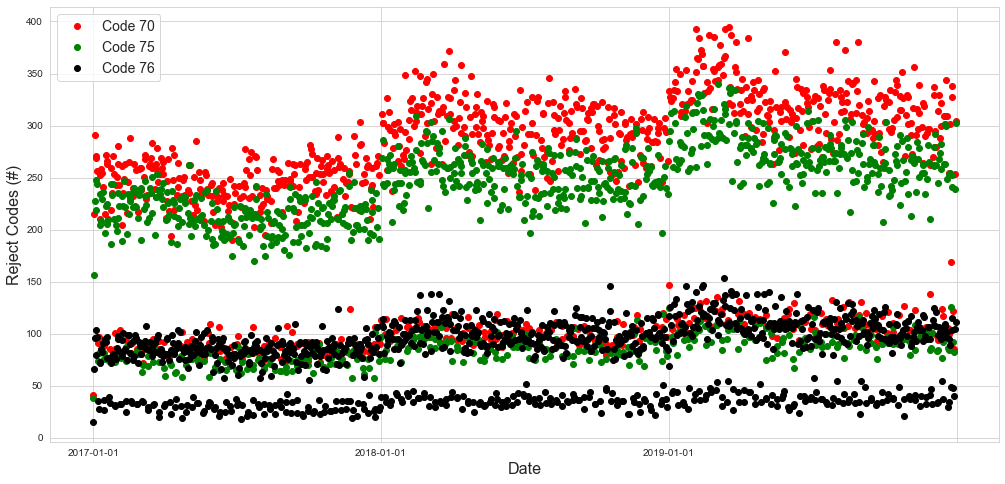

In [134]:
##Plot Reject Codes vs. Time

# import constants for the days of the week
from matplotlib.dates import MonthLocator
from matplotlib.dates import YearLocator
#from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

# tick on mondays every week
#xmajor_locator = WeekdayLocator(byweekday=MO)
xmajor_locator = YearLocator()
xminor_locator = MonthLocator()

plt.figure(figsize=(17,8))

#plt.plot(D,rclaims[:,0],'bo',label='Direct Approvals')
plt.plot(D,rclaims[:,1],'ro',label='Code 70')
plt.plot(D,rclaims[:,2],'go',label='Code 75')
plt.plot(D,rclaims[:,3],'ko',label='Code 76')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Reject Codes (#)", fontsize=16)
plt.legend(fontsize = 14,loc='best')

ax=plt.gca()
ax.xaxis.set_major_locator(xmajor_locator)
ax.xaxis.set_minor_locator(xminor_locator)

plt.show()

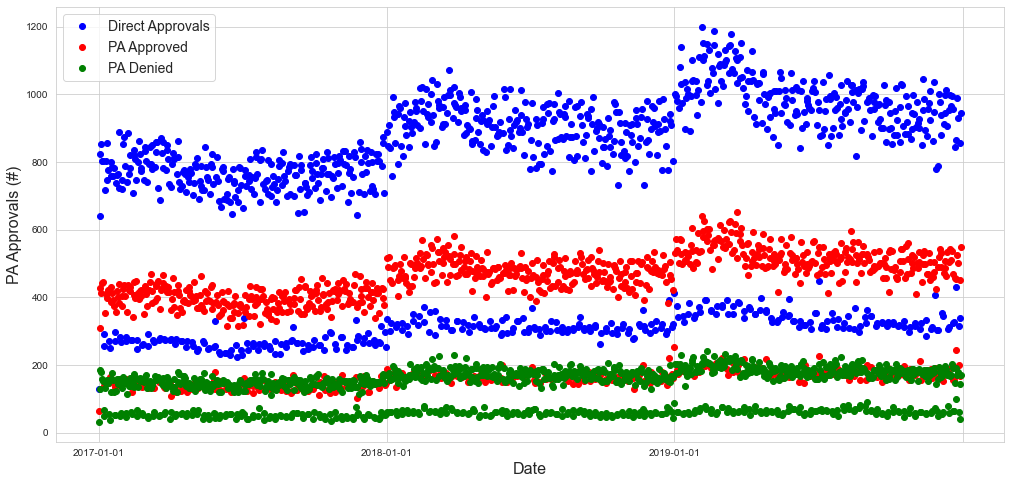

In [132]:
##Plot PA Approval vs. Time
import datetime
# import constants for the days of the week
from matplotlib.dates import MonthLocator
from matplotlib.dates import YearLocator
#from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

# tick on mondays every week
#xmajor_locator = WeekdayLocator(byweekday=MO)
xmajor_locator = YearLocator()
xminor_locator = MonthLocator()

plt.figure(figsize=(17,8))

plt.plot(D,paapprv[:,0],'bo',label='Direct Approvals')
plt.plot(D,paapprv[:,1],'ro',label='PA Approved')
plt.plot(D,paapprv[:,2],'go',label='PA Denied')

plt.xlabel("Date", fontsize=16)
plt.ylabel("PA Approvals (#)", fontsize=16)
plt.legend(fontsize = 14,loc='best')

ax=plt.gca()
ax.xaxis.set_major_locator(xmajor_locator)
ax.xaxis.set_minor_locator(xminor_locator)

#ax.set_xlim()

plt.show()